In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sympy as sm
import copy
from sympy.abc import *
sm.init_printing()
import fftrefm
reload(fftrefm)
from fftrefm import DDHOZ, DDHOZi, vary_dict, LDS
from scipy import integrate, signal
from scipy.optimize import curve_fit
import tqdm
import sigutils

In [2]:
params_full = dict(omega_0=2*np.pi*0.065,
             k=3.5,
             Q=26000.0,
             C=1e-3,
             C2q=0.65e-4,
             C2D=0.65e-4,
             Rs=200,
             Cs=1e-3,
             Vt=lambda t: 0)

T0 = (1/params_full['omega_0']) / (2*np.pi)
dt = T0/4
T = 40000
N = int(T/dt)
t = np.arange(N) * dt

params_full['Ci'] = 0.001
params_full['Ri'] = 200000

sim_params=dict(A=0.05, t=t)

ddhozi = DDHOZi(**params_full)

# # y0zi = np.array([0.00, 0, -1e-3*5, ])

In [3]:
Ris = np.logspace(3, 6, 4)
bas = [fftrefm.tf2rc(**params) for params in vary_dict(params_full, 'Ri', Ris)]

In [4]:
zs = np.array([np.polyval(ba[0], (2*np.pi*0.065j)) / np.polyval(ba[1], (2*np.pi*0.065j)) for ba in bas])

In [5]:
params_full['omega_0']/(2*np.pi) * 1e6 / (4*params_full['k']) * (params_full['C2q'] + params_full['C2D']*zs.real)

array([0.53355869, 0.50260429, 0.50274535, 0.50281866])

In [6]:
params_dicts = list(vary_dict(params_full, 'Ri', Ris))

In [7]:
tot = 50
pbar = tqdm.tqdm_notebook(total=tot*len(Ris))
lds_s = [LDS(3e-5, 1e-2, tot, 5, params, sim_params, pbar) for params in vary_dict(params_full, 'Ri', Ris)]

In [8]:
freqs = [lds.fms for lds in lds_s]
zs = [np.array(lds.out.z) for lds in lds_s]

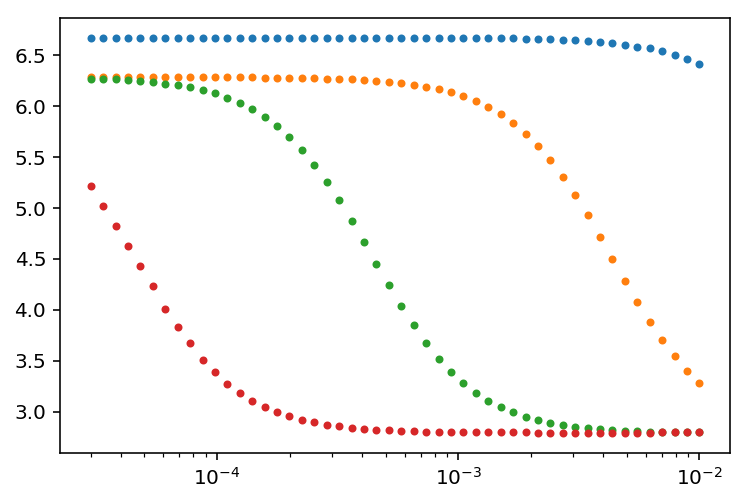

In [9]:
for freq,  z in zip(freqs, zs):
    plt.semilogx(freq, z.real, '.')

In [10]:
def lds_value(ba, fc, fm, C2q, C2D, Vm=1, k0=3.5):
    H = lambda f: np.polyval(ba[0], 2j*np.pi*f) / np.polyval(ba[1], 2j*np.pi*f)

    Hbar = (H(fm + fc) + H(fm-fc))/2
    return -fc * Vm**2 / (8 * k0) * (C2q + C2D * Hbar) * H(fm)**2 * 1e6 # MHz to Hz

In [11]:
fc = params_full['omega_0']/(2*np.pi)
sim_freqs = np.array([lds_value(ba, fc, freq, params_full['C2q'], params_full['C2D'], 5, 3.5) for ba in bas])

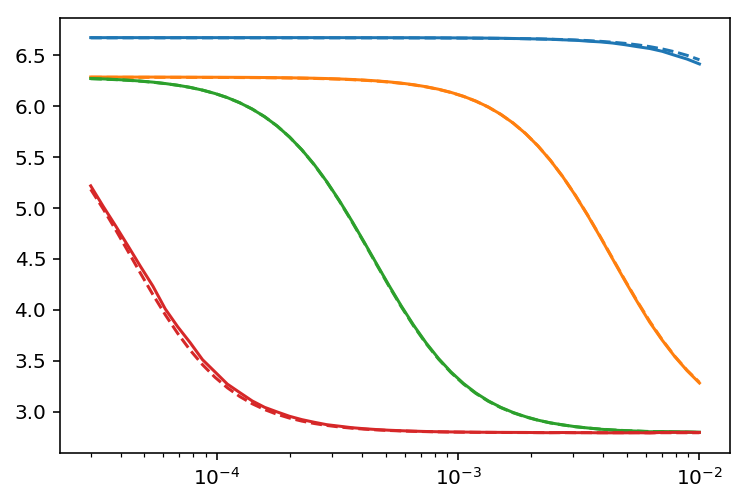

In [12]:
for freq,  z, sim_freq in zip(freqs, zs, sim_freqs):
    line, = plt.semilogx(freq, z.real)
    plt.semilogx(freq, -sim_freq.real, color=line.get_color(), linestyle='--')

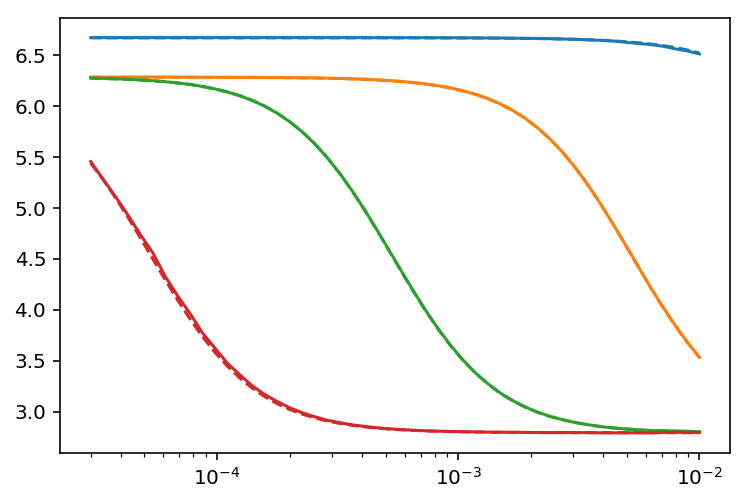

In [13]:
for freq,  z, sim_freq in zip(freqs, zs, sim_freqs):
    line, = plt.semilogx(freq, abs(z))
    plt.semilogx(freq, abs(sim_freq), color=line.get_color(), linestyle='--')

In [14]:
y_outs = [lds.out.y_out for lds in lds_s]
ddhos = [lds.ddhos for lds in lds_s]

# Saving results

In [18]:
import json_tricks
    
fh = open('../results/Fig13-lds-simulation.json', 'w')
readme = """
Readme
======
This file contains data for plots showing the results of simulating
the local dielectric spectroscopy experiment.

The lds simulations were performed using the command:

    lds_s = [LDS(3e-5, 1e-2, 50, 5, params, sim_params)
             for params in tqdm.tqdm(list(vary_dict(params_full, 'Ri', Ris)))]

The modulation voltage was 5 volts (4th argument of LDS command).

"""

params_full_no_V = copy.copy(params_full)
del params_full_no_V['Vt']

fh.write(json_tricks.dumps(dict(readme=readme,
                    freqs=freqs,
                    zs=zs,
                    sim_freqs=sim_freqs,
                    params_full=params_full_no_V,
                    sim_params=sim_params,
                    Ris=Ris,
                    bas=bas
                     ), indent=2))
fh.close()